<a href="https://colab.research.google.com/github/matthew-mcateer/noise-weight-theft/blob/master/qmnist_extract.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime, os
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from itertools import cycle
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
%config InlineBackend.figure_format = 'retina'


Using TensorFlow backend.


In [0]:
%config InlineBackend.figure_format = 'retina'

!wget -q https://github.com/facebookresearch/qmnist/raw/master/qmnist-test-images-idx3-ubyte.gz
!wget -q https://github.com/facebookresearch/qmnist/raw/master/qmnist-test-labels-idx1-ubyte.gz
!wget -q https://github.com/facebookresearch/qmnist/raw/master/qmnist-test-labels-idx2-int.gz
!wget -q https://github.com/facebookresearch/qmnist/raw/master/qmnist-test-labels.tsv.gz
!wget -q https://github.com/facebookresearch/qmnist/raw/master/qmnist-train-images-idx3-ubyte.gz
!wget -q https://github.com/facebookresearch/qmnist/raw/master/qmnist-train-labels-idx2-int.gz
!wget -q https://github.com/facebookresearch/qmnist/raw/master/qmnist-train-labels.tsv.gz
!wget -q https://github.com/facebookresearch/qmnist/raw/master/xnist-images-idx3-ubyte.xz
!wget -q https://github.com/facebookresearch/qmnist/raw/master/xnist-labels-idx2-int.xz
!wget -q https://github.com/facebookresearch/qmnist/raw/master/xnist-labels.tsv.xz

!gunzip qmnist-test-images-idx3-ubyte.gz
!gunzip qmnist-test-labels-idx1-ubyte.gz
!gunzip qmnist-test-labels-idx2-int.gz
!gunzip qmnist-test-labels.tsv.gz
!gunzip qmnist-train-images-idx3-ubyte.gz
!gunzip qmnist-train-labels-idx2-int.gz
!gunzip qmnist-train-labels.tsv.gz

In [0]:
import codecs
import numpy as np
import torch

def get_int(b):
    return int(codecs.encode(b, 'hex'), 16)

def open_maybe_compressed_file(path):
    if path.endswith('.gz'):
        return gzip.open(path, 'rb')
    elif path.endswith('.xz'):
        return lzma.open(path, 'rb')
    else:
        return open(path,'rb')
    
def read_idx2_int(path):
    with open_maybe_compressed_file(path) as f:
        data = f.read()
        assert get_int(data[:4]) == 12*256 + 2
        length = get_int(data[4:8])
        width = get_int(data[8:12])
        parsed = np.frombuffer(data, dtype=np.dtype('>i4'), offset=12)
        return torch.from_numpy(parsed.astype('i4')).view(length,width).long().numpy()

def read_idx3_ubyte(path):
    with open_maybe_compressed_file(path) as f:
        data = f.read()
        assert get_int(data[:4]) == 8 * 256 + 3
        length = get_int(data[4:8])
        num_rows = get_int(data[8:12])
        num_cols = get_int(data[12:16])
        parsed = np.frombuffer(data, dtype=np.uint8, offset=16)
        return torch.from_numpy(parsed).view(length, num_rows, num_cols).numpy()

In [4]:
x_train = read_idx3_ubyte('qmnist-train-images-idx3-ubyte')
y_train = read_idx2_int('qmnist-train-labels-idx2-int')
x_test = read_idx3_ubyte('qmnist-test-images-idx3-ubyte')
y_test = read_idx2_int('qmnist-test-labels-idx2-int')
y_train = y_train[:,0].astype('float32')
y_test = y_test[:,0].astype('float32')

print("x_train: {}, {}, {}".format(x_train.shape, type(x_train), type(x_train[0][0][0])))
print("y_train: {}, {}, {}".format(y_train.shape, type(y_train), type(y_train[0])))
print("x_test:  {}, {}, {}".format(x_test.shape, type(x_test), type(x_test[0][0][0])))
print("y_test:  {}, {}, {}".format(y_test.shape, type(y_test), type(y_test[0])))

x_train: (60000, 28, 28), <class 'numpy.ndarray'>, <class 'numpy.uint8'>
y_train: (60000,), <class 'numpy.ndarray'>, <class 'numpy.float32'>
x_test:  (60000, 28, 28), <class 'numpy.ndarray'>, <class 'numpy.uint8'>
y_test:  (60000,), <class 'numpy.ndarray'>, <class 'numpy.float32'>


In [5]:
batch_size = 128
num_classes = 10
epochs = 12 # TODO

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
60000 test samples


In [6]:
##### COMPLEMENT CODE #####
#x_train = 1.0 - x_train
#x_test = 1.0 - x_test
##### /COMPLEMENT CODE ####

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 60000 samples, validate on 60000 samples
Epoch 1/12
60000/60000 [==============================] - 23s 381us/step - loss: 0.2603 - acc: 0.9189 - val_loss: 0.0673 - val_acc: 0.9788
Epoch 2/12
60000/60000 [==============================] - 11s 183us/step - loss: 0.0881 - acc: 0.9744 - val_loss: 0.0516 - val_acc: 0.9834
Epoch 3/12
60000/60000 [==============================] - 11s 185us/step - loss: 0.0651 - acc: 0.9804 - val_loss: 0.0438 - val_acc: 0.9863
Epoch 4/12
60000/60000 [==============================] - 11s 181us/step - loss: 0.0547 - acc: 0.9843 - val_loss: 0.0418 - val_acc: 0.9866
Epoch 5/12
60000/60000 [==============================] - 11s 183us/step - loss: 0.0473 - acc: 0.9855 - val_loss: 0.0434 - val_acc: 0.9864
Epoch 6/12
60000/60000 [===============

In [0]:
pixel_batch = []

for i in range(28):
    for j in range(28):
        pix_img = np.zeros_like(x_train[0])
        pix_img[i, j, 0] = 1.0 # Could also try random [0, 1] values
        pixel_batch.append(pix_img)
    
pixel_batch = np.stack(pixel_batch)

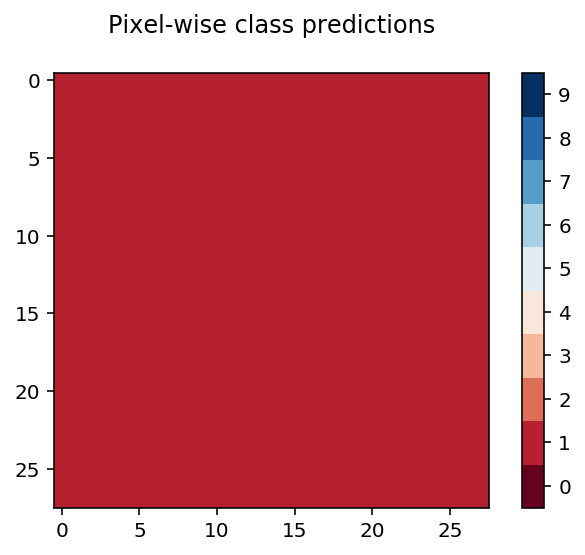

In [8]:
pix_softmax = model.predict(pixel_batch).reshape([28, 28, 10])
pix_predictions = model.predict_classes(pixel_batch).reshape([28, 28])

def discrete_matshow(data):
    #get discrete colormap
    mx = 9
    mn = 0
    cmap = plt.get_cmap('RdBu', mx-mn+1)
    # set limits .5 outside true range
    mat = plt.imshow(data,cmap=cmap,vmin = mn-.5, vmax = mx+.5)
    #tell the colorbar to tick at integers
    cax = plt.colorbar(mat, ticks=np.arange(mn,mx+1))

                       
discrete_matshow(pix_predictions)
plt.title("Pixel-wise class predictions\n")
plt.savefig('qmnist_pixel_class_pred.png')
plt.show()

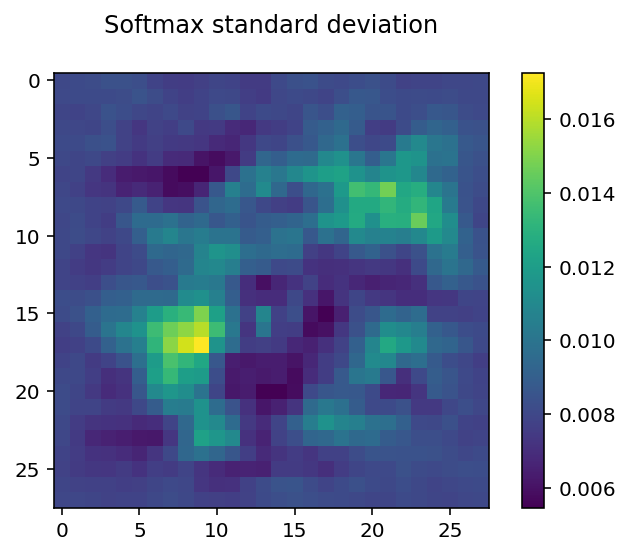

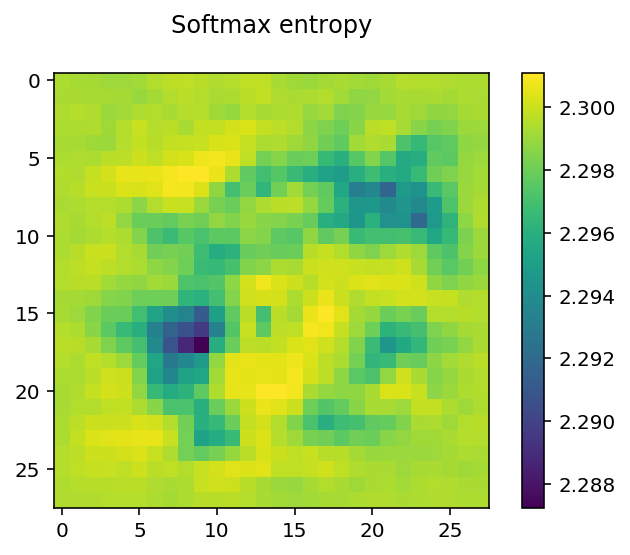

In [9]:
softmax_std = np.std(pix_softmax, axis=2).reshape(28, 28)
softmax_ent = -np.sum(pix_softmax * np.log(pix_softmax), axis=2)

plt.imshow(softmax_std)
plt.colorbar()
plt.title("Softmax standard deviation\n")
plt.savefig('qmnist_pixel_sd.png')
plt.show()

plt.imshow(softmax_ent)
plt.colorbar()
plt.title("Softmax entropy\n")
plt.savefig('qmnist_pixel_entropy.png')
plt.show()


In [0]:
def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log(np.abs(matrix).max()) / np.log(2))

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(np.abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()
    
def shift_scale(x):
  
    mu = np.mean(x)
    sig = np.std(x)
  
    return (x - mu) / sig

Among each class in isolation, what regions correspond to higher or lower z-scored softmax outputs?


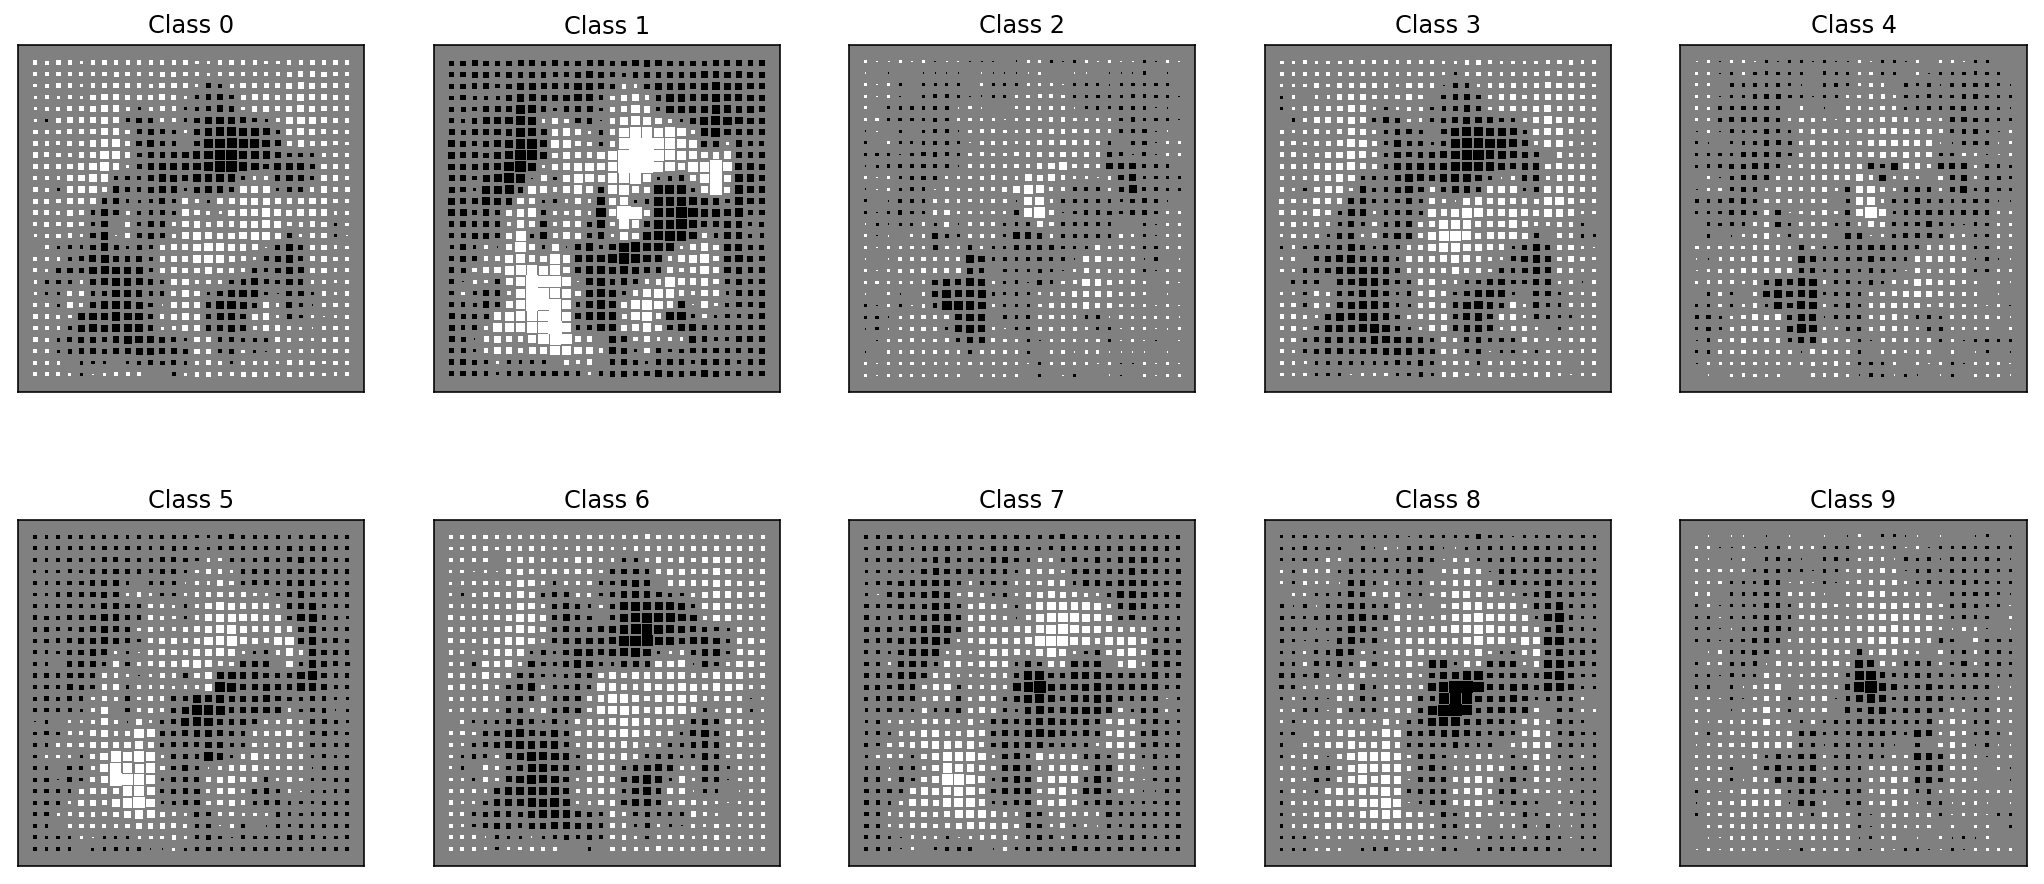

In [11]:
print('Among each class in isolation, ' +
      'what regions correspond to higher or lower z-scored softmax outputs?')
fig, ax = plt.subplots(2, 5, figsize=(18, 8))
for i in range(10):
    ax[i // 5, i % 5].set_title('Class {}'.format(i))
    hinton(shift_scale(pix_softmax[:, :, i]), ax=ax[i // 5, i % 5])
    
plt.savefig('qmnist_hinton_intra_class.png')
plt.show()

How about when we z-score the outputs globally?


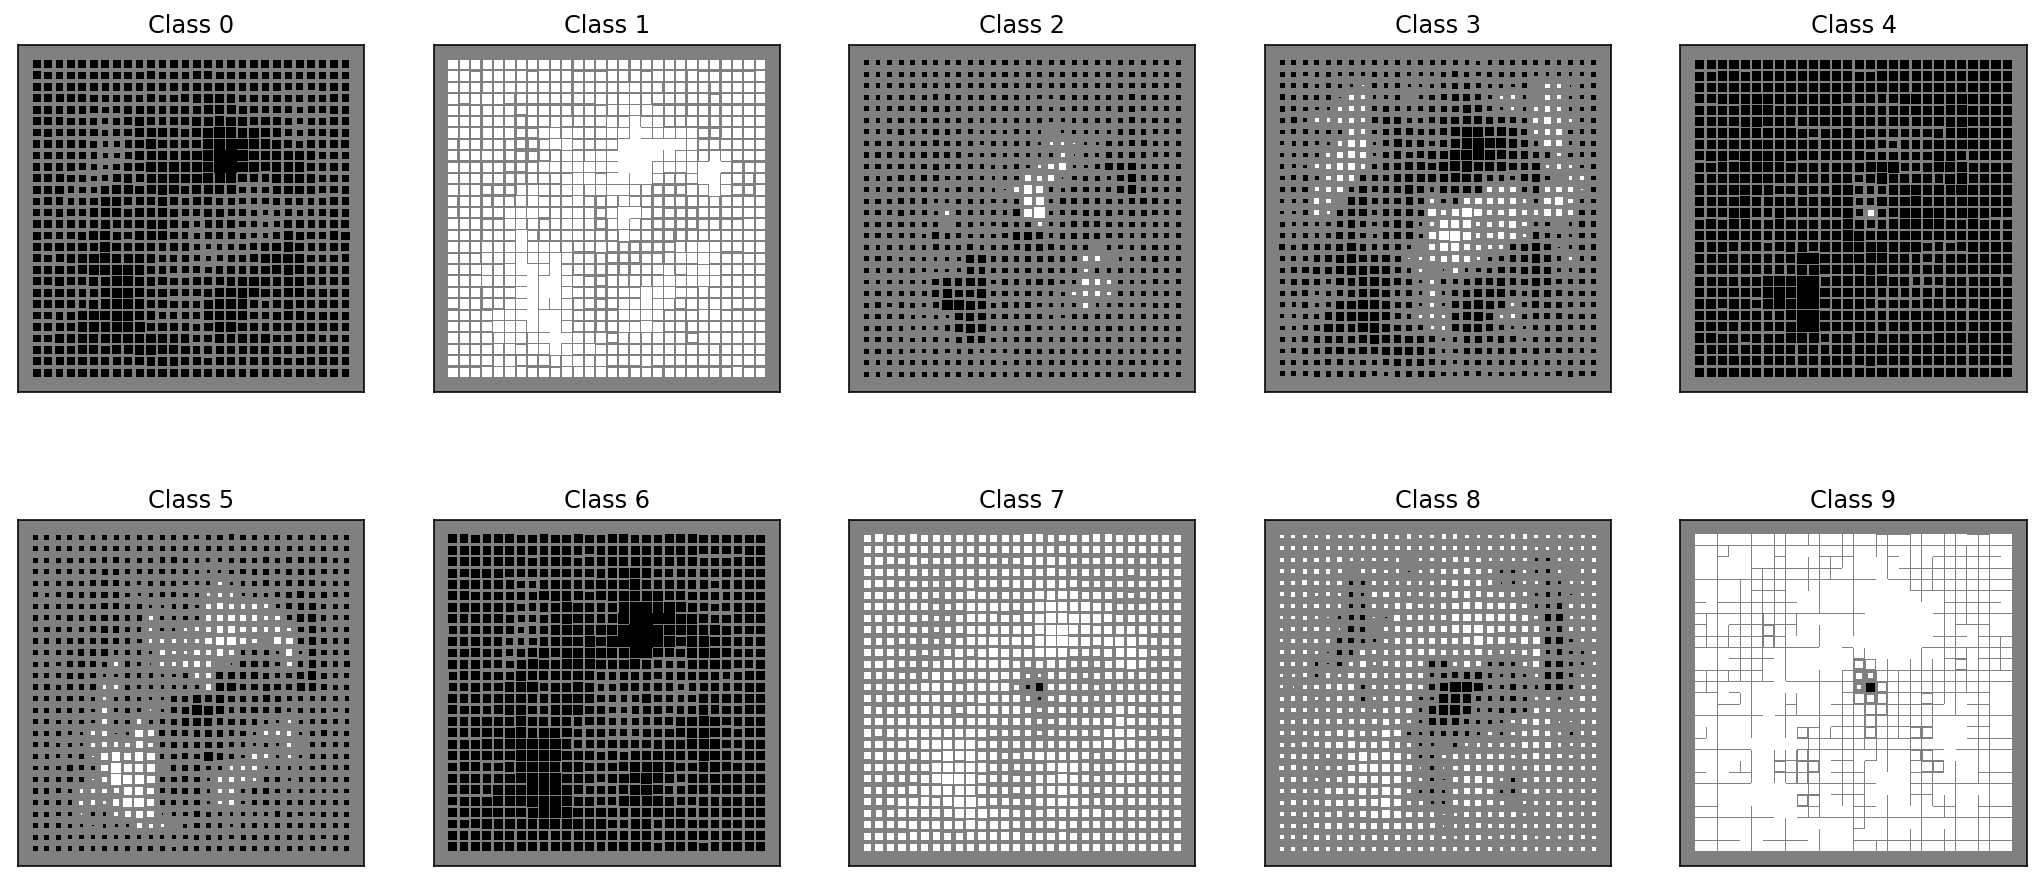

In [12]:
print('How about when we z-score the outputs globally?')
fig, ax = plt.subplots(2, 5, figsize=(18, 8))
for i in range(10):
    ax[i // 5, i % 5].set_title('Class {}'.format(i))
    hinton((pix_softmax[:, :, i] - np.mean(pix_softmax)) / np.std(pix_softmax), 
           ax=ax[i // 5, i % 5])
    
plt.savefig('qmnist_hinton_inter_class.png')
plt.show()

In [0]:
# Among each class in isolation, what regions in single-pixel space 
# yield higher probabilities

x_rand = []
y_rand = []
for p in np.arange(0.01, 1, 0.1):
    x_rand.append(np.random.standard_normal(size=(6000, 28, 28, 1)))
    y_rand.append(model.predict(x_rand[-1]))

x_rand = np.vstack(x_rand)
y_rand = np.vstack(y_rand)

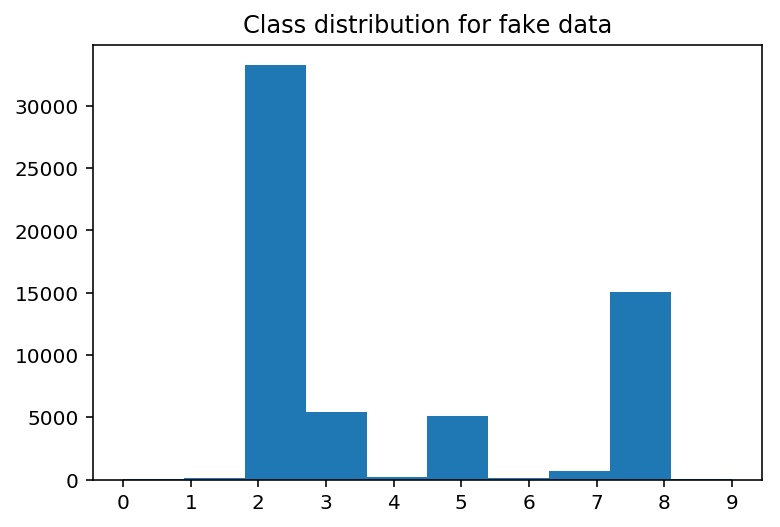

In [14]:
plt.xticks(np.arange(0, 10, step=1))
plt.title('Class distribution for fake data')
plt.hist(np.argmax(y_rand, axis=1))
plt.savefig('qmnist_class_dist.png')
plt.show()

In [15]:
class_weights = compute_class_weight('balanced', np.unique(np.argmax(y_rand, axis=1)), np.argmax(y_rand, axis=1), )
class_weights

array([6.00000000e+02, 6.52173913e+01, 1.80494555e-01, 1.11275964e+00,
       2.58620690e+01, 1.17141742e+00, 4.76190476e+01, 8.54700855e+00,
       3.98274145e-01, 3.52941176e+02])

In [16]:
for i in range(10):
    print(i, np.sum(np.argmax(y_rand, axis=1) == i))

0 10
1 92
2 33242
3 5392
4 232
5 5122
6 126
7 702
8 15065
9 17


In [17]:
'''Trains a simple convnet on the QMNIST dataset.

Gets to 99.25% test accuracy after 12 epochs
(there is still a lot of margin for parameter tuning).
16 seconds per epoch on a GRID K520 GPU.
'''

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
#(x_train, y_train) = (pixel_batch, pix_softmax_lin)
(x_train, y_train) = (x_rand, y_rand)

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
60000 test samples


In [18]:
# convert class vectors to binary class matrices
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

model_steal = Sequential()
model_steal.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model_steal.add(Conv2D(64, (3, 3), activation='relu'))
model_steal.add(MaxPooling2D(pool_size=(2, 2)))
#model_steal.add(Dropout(0.25))
model_steal.add(Flatten())
model_steal.add(Dense(128, activation='relu'))
#model_steal.add(Dropout(0.5))
model_steal.add(Dense(num_classes, activation='softmax'))
'''

model_steal = Sequential()

model_steal.add(Conv2D(6, 5, 5, border_mode='valid', input_shape = (28,28,1)))
model_steal.add(MaxPooling2D(pool_size=(2, 2)))
model_steal.add(Activation("sigmoid"))

model_steal.add(Conv2D(16, 5, 5, border_mode='valid'))
model_steal.add(MaxPooling2D(pool_size=(2, 2)))
model_steal.add(Activation("sigmoid"))
#model_steal.add(Dropout(0.5))

model_steal.add(Conv2D(120, 1, 1, border_mode='valid'))

model_steal.add(Flatten())
model_steal.add(Dense(84))
model_steal.add(Activation("sigmoid"))
model_steal.add(Dense(10))
model_steal.add(Activation('softmax'))
'''


'\n\nmodel_steal = Sequential()\n\nmodel_steal.add(Conv2D(6, 5, 5, border_mode=\'valid\', input_shape = (28,28,1)))\nmodel_steal.add(MaxPooling2D(pool_size=(2, 2)))\nmodel_steal.add(Activation("sigmoid"))\n\nmodel_steal.add(Conv2D(16, 5, 5, border_mode=\'valid\'))\nmodel_steal.add(MaxPooling2D(pool_size=(2, 2)))\nmodel_steal.add(Activation("sigmoid"))\n#model_steal.add(Dropout(0.5))\n\nmodel_steal.add(Conv2D(120, 1, 1, border_mode=\'valid\'))\n\nmodel_steal.add(Flatten())\nmodel_steal.add(Dense(84))\nmodel_steal.add(Activation("sigmoid"))\nmodel_steal.add(Dense(10))\nmodel_steal.add(Activation(\'softmax\'))\n'

In [19]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)

model_steal.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model_steal.fit(x_train, y_train,
               batch_size=batch_size,
               epochs=10, # TODO
               verbose=1,
               validation_data=(x_test, y_test), 
               class_weight=class_weights,
               callbacks=[tensorboard_callback])


score = model_steal.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Train on 60000 samples, validate on 60000 samples
Epoch 1/10
  896/60000 [..............................] - ETA: 54s - loss: 2.2028 - acc: 0.3884 

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.346276). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.178331). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


60000/60000 [==============================] - 14s 233us/step - loss: 1.0767 - acc: 0.6320 - val_loss: 1.9703 - val_acc: 0.3753
Epoch 2/10
60000/60000 [==============================] - 14s 226us/step - loss: 0.7185 - acc: 0.7882 - val_loss: 1.6598 - val_acc: 0.4623
Epoch 3/10
60000/60000 [==============================] - 13s 224us/step - loss: 0.6536 - acc: 0.8202 - val_loss: 1.5620 - val_acc: 0.5267
Epoch 4/10
60000/60000 [==============================] - 13s 225us/step - loss: 0.6224 - acc: 0.8399 - val_loss: 1.3975 - val_acc: 0.5896
Epoch 5/10
60000/60000 [==============================] - 14s 225us/step - loss: 0.5996 - acc: 0.8573 - val_loss: 1.3567 - val_acc: 0.5860
Epoch 6/10
60000/60000 [==============================] - 13s 222us/step - loss: 0.5808 - acc: 0.8719 - val_loss: 1.2786 - val_acc: 0.6136
Epoch 7/10
60000/60000 [==============================] - 14s 225us/step - loss: 0.5643 - acc: 0.8869 - val_loss: 1.2418 - val_acc: 0.6164
Epoch 8/10
60000/60000 [==============

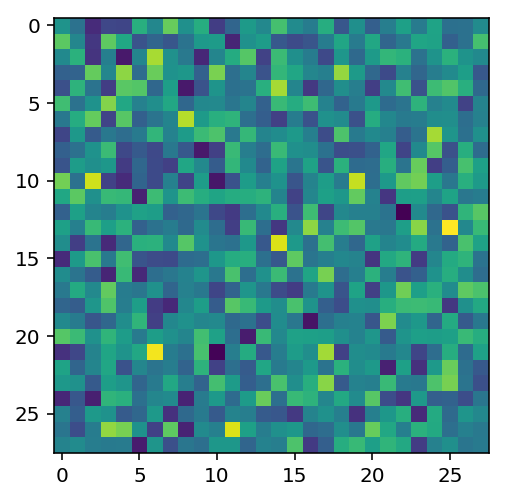

In [20]:
plt.imshow(x_train[50000, :, :, 0])
plt.savefig('qmnist_rand_example.png')
plt.show()

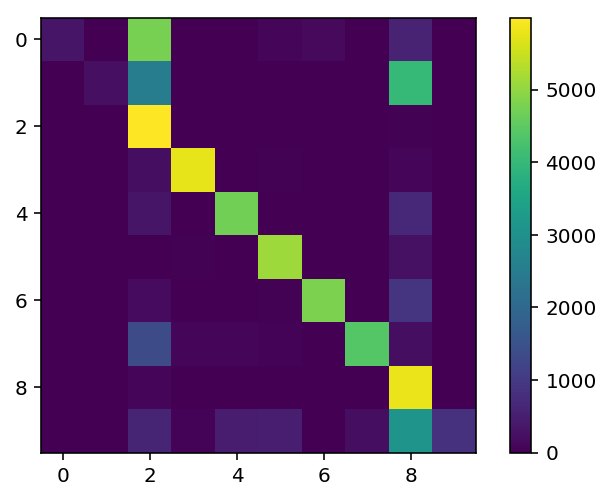

In [21]:
y_pred = model_steal.predict(x_test)

matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
plt.imshow(matrix)
plt.colorbar()
plt.savefig('qmnist_confusion.png')
plt.show()

In [22]:
n_classes = 10
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_pred[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_pred[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
    y_pred.ravel())
average_precision["micro"] = average_precision_score(y_test, y_pred,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.73


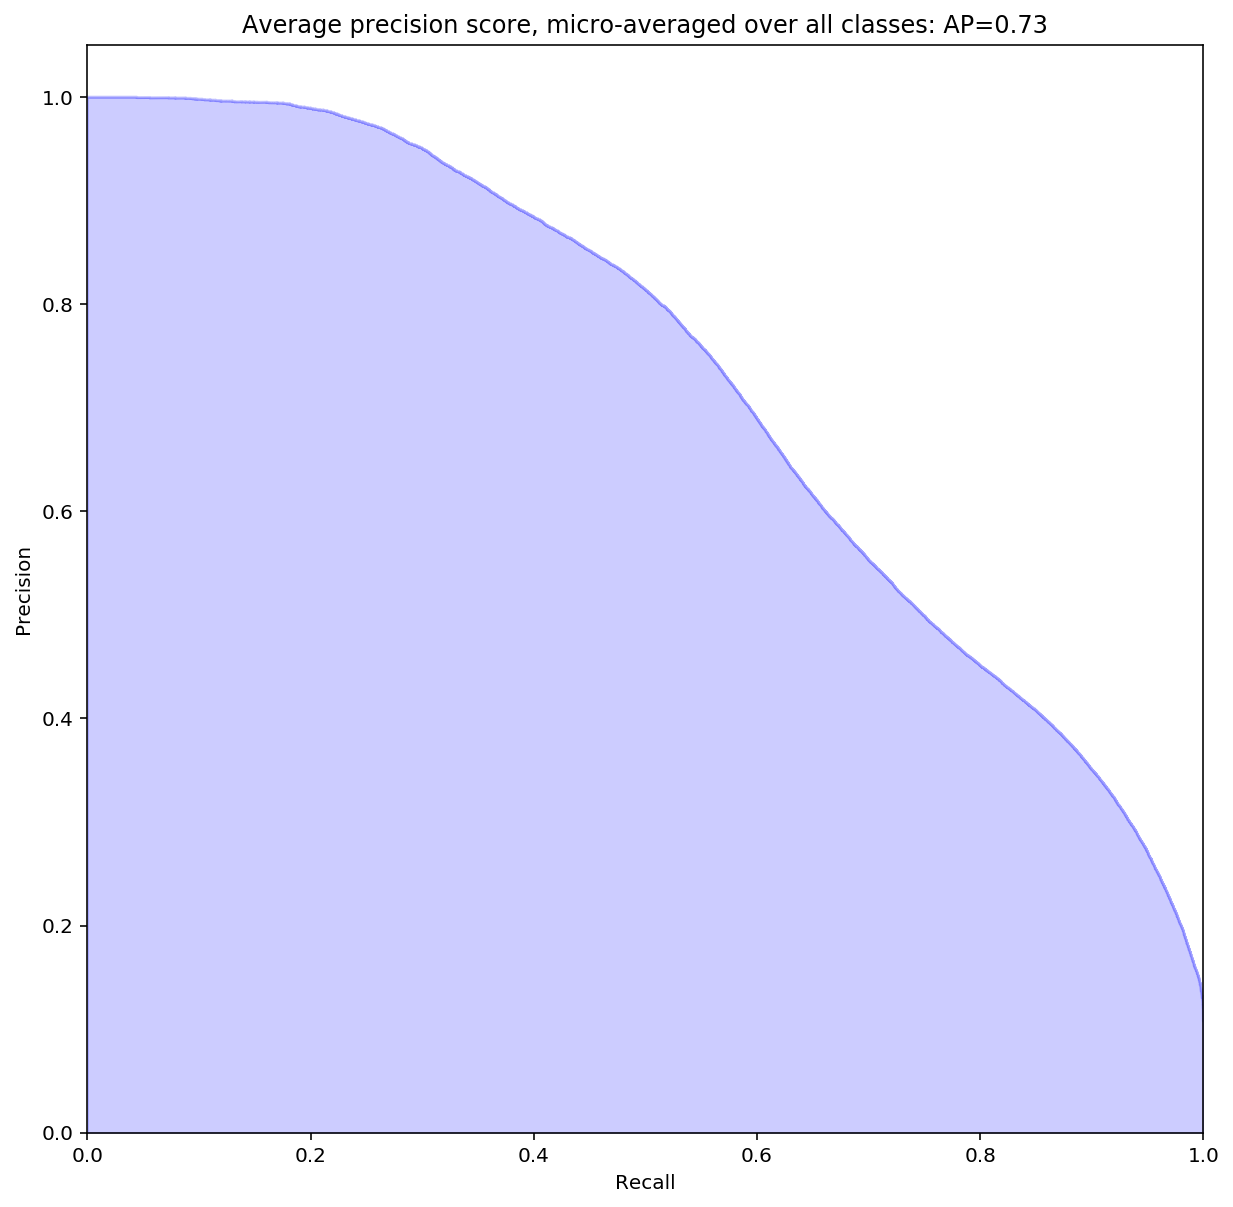

In [23]:
plt.figure(figsize=(10, 10))
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))
plt.savefig('qmnist_pr_ma.png')
plt.show()

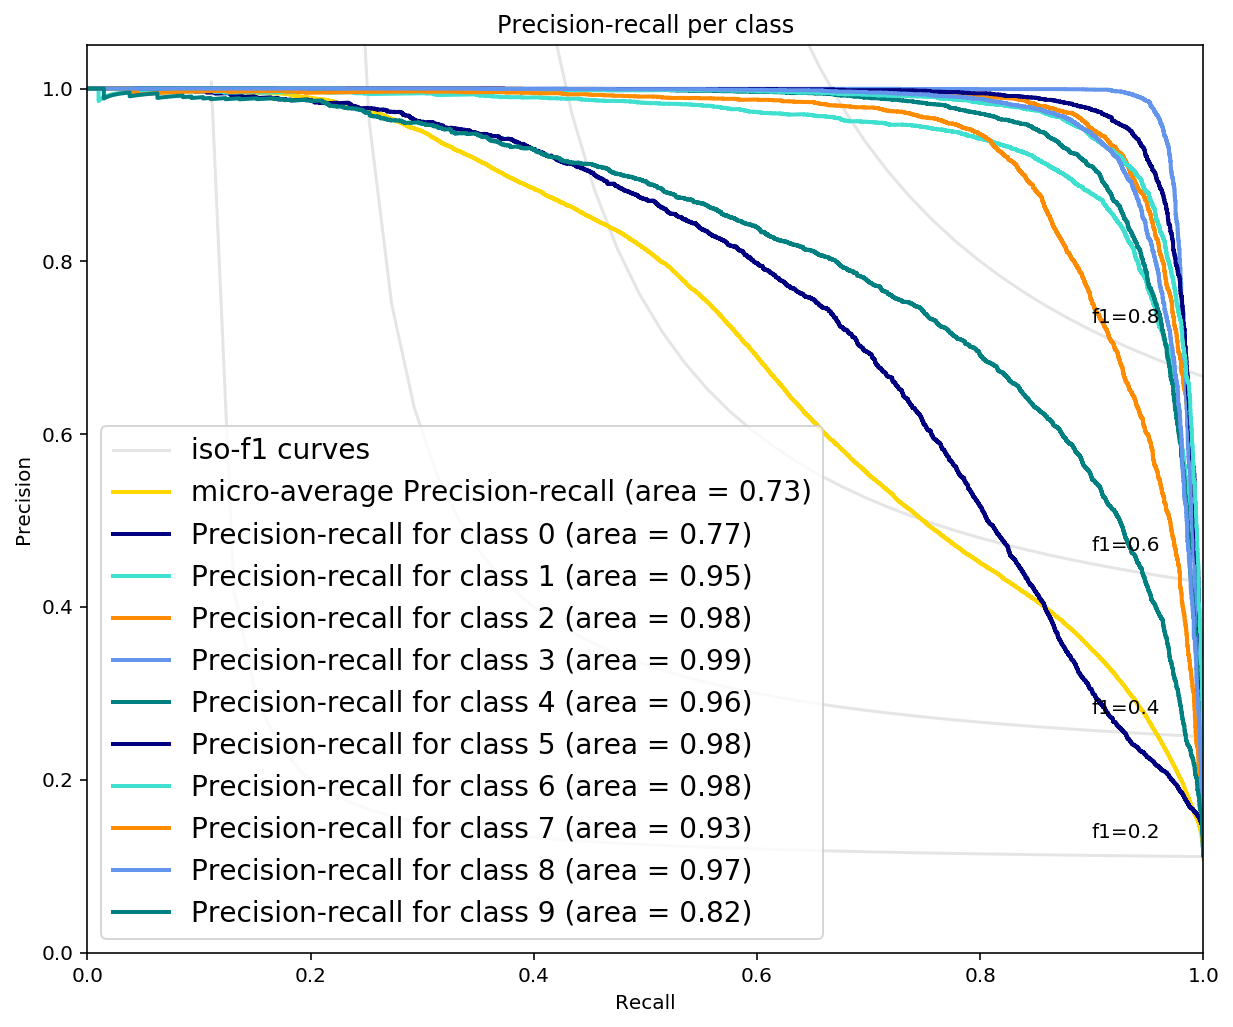

In [24]:
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(10, 10))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-recall per class')
plt.legend(lines, labels, prop=dict(size=14))

plt.savefig('qmnist_pr_multi.png')
plt.show()

In [25]:
x_test[0, :, :, 0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.    